In [98]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [99]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


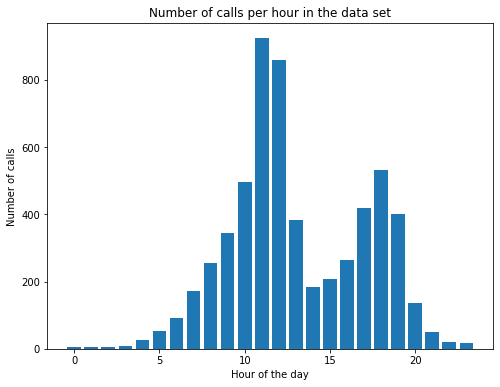

In [100]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls')
plt.title('Number of calls per hour in the data set')
plt.show()

In [101]:
hours_data = []
for hour_index in range(24):
    waiting_times_hour = waiting_times_per_hour[hour_index]
    hours_data.append(waiting_times_hour)


In [102]:
waiting_times_hour = waiting_times_per_hour[1]
waiting_times_hour

[24.0, 4.8, 24.0, 14.0]

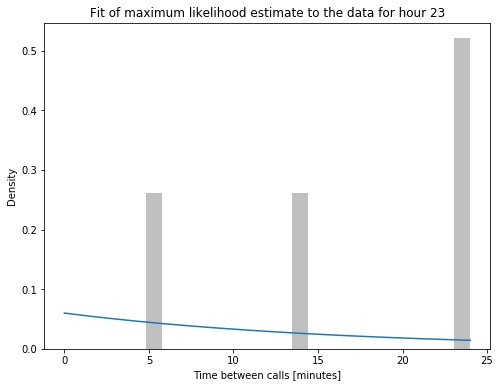

In [103]:
# Exponential distribution with maximum likelihood fit to the data
lambda_ = 1 / np.mean(waiting_times_hour)
distribution = sts.expon(scale=1/lambda_)
plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
y = distribution.pdf(x)
plt.plot(x, y)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.show()

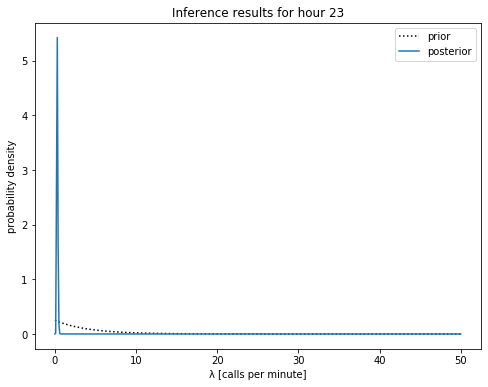

In [108]:
# THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.
posteriorlist = []
# Likelihood: P(data | param)
def likelihood(lambda_, datum):
    # return sts.expon.pdf(datum, scale=1/lambda_)
    return sts.expon(scale=1/lambda_).pdf(datum)
# THE PRIOR DISTRIBUTION
#
# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

# Prior: P(param)
def prior(lambda_):
    alpha = 1
    beta = 0.25
    return sts.gamma(a=alpha, scale=1/beta).pdf(lambda_)

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

lambdas = np.linspace(0, 50, 500)  # YOU NEED TO COMPLETE THIS.
for i in range(24): 
    posterior = compute_posterior(lambdas, prior, likelihood, hours_data[i])
    posteriorlist.append(posterior)
# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, label='posterior')
#plt.plot(lambas, likelihood(lambdas), label = 'likelihood')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour {hour_index}')
plt.legend()
plt.show()

In [105]:
hours_data[1]

[24.0, 4.8, 24.0, 14.0]

In [106]:
meanlist = []
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]
'''
The following loop is to calculate the mean of the distribution for each of the hours. 
The loop loops over the 24 hours given in the dataset. The loop takes the values of the lambdas. 
'''
for u in range(24):
    mean = sp.integrate.trapz(posteriorlist[u] * lambdas, lambdas)
    meanlist.append(mean)


In [109]:
'''
The two lists contain the the lower and the upper bounds for the posterior confidence intervals. 
The for loop loops over all the hours recorded and computes the 98 %confidence interval over
the posterior values recorded for each hour.
'''
lowerbound = []
higherbound = []
percentiles = []
for m in range(24):
    percentiles.append([compute_percentile(lambdas, posteriorlist[m], p)
                        for p in [0.01, 0.99]])
    lowerbound.append(percentiles[m][0])
    higherbound.append(percentiles[m][1])

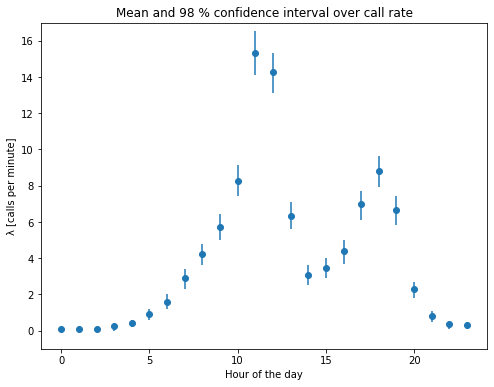

In [110]:
plt.figure(figsize=(8, 6))
plt.ylim(-1,17)
lowerbound2 = []
higherbound2 = []
for i in range (24):
    lowerbound2.append(meanlist[i] - lowerbound[i])
    higherbound2.append(higherbound[i]- meanlist[i])
plt.errorbar(range(24), meanlist, yerr=[lowerbound2,higherbound2], fmt='o')
plt.xlabel('Hour of the day')
plt.ylabel('λ [calls per minute]')
plt.title("Mean and 98 % confidence interval over call rate")
plt.show()

In [70]:
hours = [x for x in range(24)]
#columns=['hours', 'higherbound', 'lowerbound']
df = pd.DataFrame(lowerbound,higherbound)
df

,0
0.200401,0.000000
0.100200,0.000000
0.200401,0.000000
0.400802,0.000000
0.601202,0.200401
1.202405,0.601202
2.004008,1.202405
3.406814,2.304609
4.809619,3.607214
6.412826,5.010020
